# Model Evaluation

In this notebook, I will test different models to classify the tweets.

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

from timeit import default_timer as timer

In [2]:
import gc

# remove unnecessary variables
def clean_up(vars_):
    for var in vars_:
        del var 
    print(gc.collect())

In [46]:
X_train = pd.read_pickle('PKL/X_train_fin.pkl')
X_val = pd.read_pickle('PKL/X_val_fin.pkl')
y_train = pd.read_csv('DATA/y_train.csv', index_col=0)
y_val = pd.read_csv('DATA/y_val.csv', index_col=0)

In [47]:
X_train_tweet = X_train['tweet']
X_val_tweet = X_val['tweet']

In [48]:
X_train = X_train.drop('tweet', axis = 1)
X_val = X_val.drop('tweet', axis = 1)

In [49]:
y_train = y_train['sentiment']
y_val = y_val['sentiment']

## Evaluation Metrics
It is a multi-class classification problem with class imbalance. Since the goal of the project is to build a model that accurately classifies positive, negative or neutral sentiment than detecting any specific class, so I'll use accuracy as a measure. I'll also look at cohen's kappa score. 

In [7]:
from sklearn.metrics import accuracy_score, cohen_kappa_score
scoreboard = {}
def scoring(title, y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    ck = cohen_kappa_score(y_test, y_pred)
    scoreboard[title] = (round(acc, 4), round(ck, 4)) 
    return scoreboard

## Class Imbalance
Currently our dataset has a class imbalance issue. I'll first try to resolve this by oversampling using SMOTE.

In [8]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(n_jobs = -1, random_state=22)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [9]:
X_train.shape

(7905, 7057)

In [10]:
y_train.value_counts()

No emotion toward brand or product    2635
Negative emotion                      2635
Positive emotion                      2635
Name: sentiment, dtype: int64

## Standardization

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

## Baseline Model 
---
First I'll run a baseline model using dummy classifier.

In [12]:
from sklearn.dummy import DummyClassifier

In [13]:
start = timer()

dummy_classifier = DummyClassifier(strategy='stratified')
dummy_classifier.fit(X_train, y_train)
y_pred = dummy_classifier.predict(X_val)

end = timer()
print(scoring('dummy', y_val, y_pred))

print('Total Time Elapsed:', end - start)

{'dummy': (0.3182, -0.0164)}
Total Time Elapsed: 0.016889871999865136


## Random Forest
---


In [14]:
from sklearn.ensemble import RandomForestClassifier
start = timer()

rfc = RandomForestClassifier(n_jobs = -2, random_state=18)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_val)

end = timer()
print(scoring('simple random forest', y_val, y_pred))

print('Total Time Elapsed:', end - start)

{'dummy': (0.3182, -0.0164), 'simple random forest': (0.6373, 0.2332)}
Total Time Elapsed: 9.749672269000257


### Hyper-parameter optimization

In [119]:
import optuna

In [120]:
def find_hyperparam_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 700)
    #max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_features = trial.suggest_int('max_features', 2, X_train.shape[1])
    min_weight_fraction_leaf = trial.suggest_loguniform('min_weight_fraction_leaf', 1e-7, 0.1)
    max_leaf_nodes= trial.suggest_int('max_leaf_nodes', 10, 200)
    rfc = RandomForestClassifier(
                                 n_estimators = n_estimators,
                                 #max_depth = max_depth, 
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 criterion = criterion,
                                 max_features = max_features,
                                 min_weight_fraction_leaf=min_weight_fraction_leaf,
                                 max_leaf_nodes = max_leaf_nodes
                                )
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(rfc, X_train, y_train,
                                    scoring = 'accuracy', cv = cv, n_jobs = -2))
    return (score)

rfc_study = optuna.create_study(direction='maximize')
rfc_study.optimize(find_hyperparam_rf, timeout = 60)

[W 2020-09-10 16:11:46,764] Trial 0 failed because of the following error: NameError("name 'KFold' is not defined")
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/optuna/study.py", line 709, in _run_trial
    result = func(trial)
  File "<ipython-input-120-dc5b1e0a5eba>", line 20, in find_hyperparam_rf
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
NameError: name 'KFold' is not defined


NameError: name 'KFold' is not defined

## SVM
---

In [15]:
from sklearn.svm import SVC

start = timer()

svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_val)

end = timer()
print(scoring('simple svm', y_val, y_pred))

print('Total Time Elapsed:', end - start)

{'dummy': (0.3182, -0.0164), 'simple random forest': (0.6373, 0.2332), 'simple svm': (0.6052, 0.1959)}
Total Time Elapsed: 589.4746815960002


### LSTM
---

In [100]:
from tensorflow.keras.layers import LSTM, Input, Embedding, GlobalMaxPool1D, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [111]:
labels_set = pd.get_dummies(y_train)
labels = labels_set.values

In [112]:
labels_set.columns

Index(['Negative emotion', 'No emotion toward brand or product',
       'Positive emotion'],
      dtype='object')

In [61]:
tokenizer = Tokenizer(num_words = 7000)
tokenizer.fit_on_texts(X_train_tweet)
seq_X_train = tokenizer.texts_to_sequences(X_train_tweet)
seq_X_train = pad_sequences(seq_X_train)

In [116]:
model = Sequential()
model.add(Embedding(7000, 64))
model.add(LSTM(30, return_sequences = True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(60, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = 'adam', 
             loss = 'categorical_crossentropy', 
             metrics = ['accuracy'])

cb = EarlyStopping(monitor = 'val_loss', verbose = 1, patience = 10, restore_best_weights = True)

start = timer()
history = model.fit(seq_X_train, labels,
                   epochs = 100, 
                   validation_split = 0.2, 
                   verbose = 2, 
                   callbacks = [cb])

end = timer()
print('Total Time Elapsed:', end-start)

Epoch 1/100
113/113 - 5s - loss: 0.9384 - accuracy: 0.5630 - val_loss: 0.8914 - val_accuracy: 0.5679
Epoch 2/100
113/113 - 2s - loss: 0.8674 - accuracy: 0.5797 - val_loss: 0.8890 - val_accuracy: 0.5679
Epoch 3/100
113/113 - 2s - loss: 0.8466 - accuracy: 0.5903 - val_loss: 0.8453 - val_accuracy: 0.5679
Epoch 4/100
113/113 - 1s - loss: 0.7422 - accuracy: 0.6602 - val_loss: 0.8739 - val_accuracy: 0.6102
Epoch 5/100
113/113 - 2s - loss: 0.6100 - accuracy: 0.7429 - val_loss: 0.8885 - val_accuracy: 0.5935
Epoch 6/100
113/113 - 2s - loss: 0.4868 - accuracy: 0.8056 - val_loss: 1.1032 - val_accuracy: 0.6102
Epoch 7/100
113/113 - 2s - loss: 0.3834 - accuracy: 0.8532 - val_loss: 1.1328 - val_accuracy: 0.6214
Epoch 8/100
113/113 - 1s - loss: 0.3149 - accuracy: 0.8808 - val_loss: 1.4568 - val_accuracy: 0.6269
Epoch 9/100
113/113 - 1s - loss: 0.2602 - accuracy: 0.9095 - val_loss: 1.6975 - val_accuracy: 0.6158
Epoch 10/100
113/113 - 1s - loss: 0.2292 - accuracy: 0.9173 - val_loss: 1.7086 - val_accura

In [87]:
#model.save('MODEL/LSTM_v1.h5')

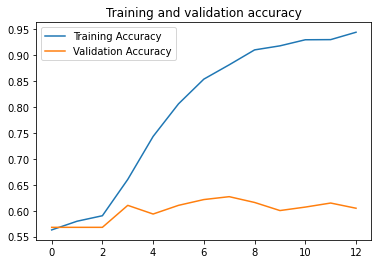

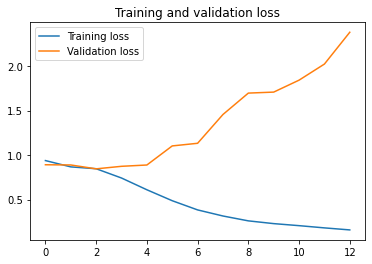

In [117]:
# plot performance
def plot_performance(hist):
    hist_ = hist.history
    epochs = hist.epoch

    plt.plot(epochs, hist_['accuracy'], label='Training Accuracy')
    plt.plot(epochs, hist_['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, hist_['loss'], label='Training loss')
    plt.plot(epochs, hist_['val_loss'], label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()
    
plot_performance(model.history)